In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
df = pd.read_csv("processed_data.csv")

embedding_caption = np.load("embedding_caption_mean.npy")
embedding_script = np.load("embedding_script_mean.npy")

In [ ]:
features_num = df[["is_ad", "is_sponsored", "author_fans"]].values
np.hstack([embedding_caption, embedding_script])

y = df["manual_score_log_class_kmeans"]
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [ ]:
X_text_train, X_text_test, features_num_train, features_num_test, y_train, y_test = train_test_split(
    X_text, features_num, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

scaler = StandardScaler()
features_num_train_scaled = scaler.fit_transform(features_num_train)
features_num_test_scaled = scaler.transform(features_num_test)

X_train = np.hstack([X_text_train, features_num_train_scaled])
X_test = np.hstack([X_text_test, features_num_test_scaled])

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)


input_size = X_train.shape[1]
num_classes = len(np.unique(y_enc))
model = MLPClassifier(input_size, num_classes)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 100

loss_history = []
acc_history = []

best_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    loss_history.append(avg_loss)
    acc_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Acc: {accuracy:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1
        print(f"  No improvement. Patience: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/100 - Loss: 1.0713 - Acc: 0.4240
Epoch 2/100 - Loss: 0.8059 - Acc: 0.7602
Epoch 3/100 - Loss: 0.6448 - Acc: 0.8779
Epoch 4/100 - Loss: 0.5175 - Acc: 0.9058
Epoch 5/100 - Loss: 0.4445 - Acc: 0.8951
Epoch 6/100 - Loss: 0.3701 - Acc: 0.9229
Epoch 7/100 - Loss: 0.3339 - Acc: 0.9165
Epoch 8/100 - Loss: 0.2647 - Acc: 0.9379
Epoch 9/100 - Loss: 0.2512 - Acc: 0.9507
Epoch 10/100 - Loss: 0.2154 - Acc: 0.9657
Epoch 11/100 - Loss: 0.1846 - Acc: 0.9700
Epoch 12/100 - Loss: 0.1859 - Acc: 0.9700
  No improvement. Patience: 1/5
Epoch 13/100 - Loss: 0.1571 - Acc: 0.9722
Epoch 14/100 - Loss: 0.1727 - Acc: 0.9743
  No improvement. Patience: 1/5
Epoch 15/100 - Loss: 0.1299 - Acc: 0.9786
Epoch 16/100 - Loss: 0.1285 - Acc: 0.9872
Epoch 17/100 - Loss: 0.1160 - Acc: 0.9850
Epoch 18/100 - Loss: 0.1211 - Acc: 0.9786
  No improvement. Patience: 1/5
Epoch 19/100 - Loss: 0.0970 - Acc: 0.9872
Epoch 20/100 - Loss: 0.0942 - Acc: 0.9893
Epoch 21/100 - Loss: 0.0978 - Acc: 0.9786
  No improvement. Patience: 1/5

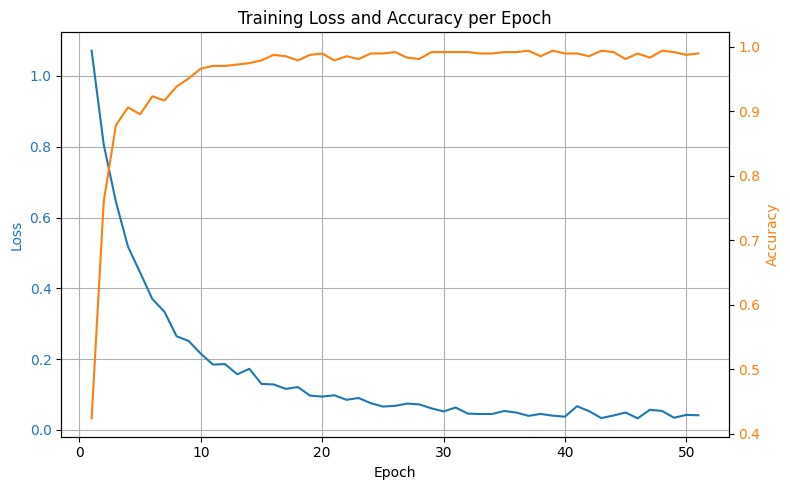

In [ ]:
epochs_range = range(1, len(loss_history) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs_range, loss_history, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs_range, acc_history, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Accuracy per Epoch')
fig.tight_layout()
plt.show()

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


=== Classification Report ===
              precision    recall  f1-score   support

        high       0.50      0.43      0.46         7
         low       0.93      0.94      0.93        96
      medium       0.71      0.71      0.71        14

    accuracy                           0.88       117
   macro avg       0.71      0.69      0.70       117
weighted avg       0.88      0.88      0.88       117

